# **Klasikasi Gambar Sayur**

### Objective :
Membangun model CNN untuk mengklasifikasikan 15 jenis sayuran dari gambar.

### Sumber Dataset :
kaggle

# **Import Library**

In [12]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model


# **Data Loading**

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nurniahamid","key":"f5ac50c26628fb88a41f246b68d97d62"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip -d vegetables

Streaming output truncated to the last 5000 lines.
  inflating: vegetables/Vegetable Images/train/Radish/0001.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0002.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0003.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0004.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0005.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0006.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0007.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0008.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0009.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0010.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0011.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0012.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0013.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0014.jpg  
  inflating: vegetables/Vegetable Image

In [5]:
base_dir = 'vegetables/Vegetable Images'
for subset in ['train', 'validation', 'test']:
    subset_dir = os.path.join(base_dir, subset)
    print(f"\n{subset_dir} contains:")
    print(os.listdir(subset_dir))


vegetables/Vegetable Images/train contains:
['Pumpkin', 'Tomato', 'Bitter_Gourd', 'Radish', 'Bean', 'Cabbage', 'Brinjal', 'Bottle_Gourd', 'Cauliflower', 'Papaya', 'Cucumber', 'Broccoli', 'Potato', 'Capsicum', 'Carrot']

vegetables/Vegetable Images/validation contains:
['Pumpkin', 'Tomato', 'Bitter_Gourd', 'Radish', 'Bean', 'Cabbage', 'Brinjal', 'Bottle_Gourd', 'Cauliflower', 'Papaya', 'Cucumber', 'Broccoli', 'Potato', 'Capsicum', 'Carrot']

vegetables/Vegetable Images/test contains:
['Pumpkin', 'Tomato', 'Bitter_Gourd', 'Radish', 'Bean', 'Cabbage', 'Brinjal', 'Bottle_Gourd', 'Cauliflower', 'Papaya', 'Cucumber', 'Broccoli', 'Potato', 'Capsicum', 'Carrot']


# **Explorasi Data**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
base_dir = 'vegetables/Vegetable Images'

train_generator = train_datagen.flow_from_directory(
    directory=f"{base_dir}/train",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory=f"{base_dir}/validation",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=f"{base_dir}/test",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


<ipython-input-8-2edb5da93301>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=distribution_df, x='labels', order=distribution_df['labels'].value_counts().index, palette="viridis")


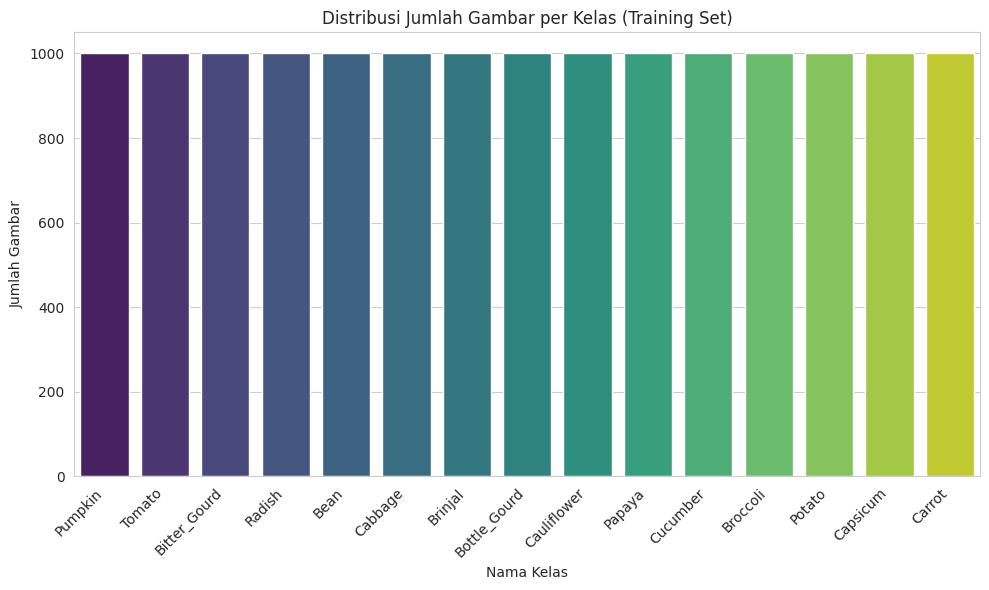

In [8]:
vegetable_path = "vegetables/Vegetable Images/train"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(vegetable_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

distribution_df = pd.DataFrame({
    "file_name": file_name,
    "path": full_path,
    "labels": labels
})

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=distribution_df, x='labels', order=distribution_df['labels'].value_counts().index, palette="viridis")
plt.title("Distribusi Jumlah Gambar per Kelas (Training Set)")
plt.xlabel("Nama Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# **Data Augmentation**

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# **Model Sequential dengan Conv2D & Pooling**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(15, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,830,287 (18.43 MB)

 Trainable params: 4,830,287 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=callbacks
)

val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
model.save("cnn_model_vegetables.h5")

best_model = load_model('best_model.h5')
val_loss, val_acc = best_model.evaluate(val_generator)
print(f"Best model validation accuracy: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2954 - loss: 2.0863
Epoch 1: val_accuracy improved from -inf to 0.63978, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 764s 2s/step - accuracy: 0.2956 - loss: 2.0856 - val_accuracy: 0.6398 - val_loss: 1.0434 - learning_rate: 0.0010
Epoch 2/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 9:41 1s/step - accuracy: 0.6562 - loss: 0.9973

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.63978
468/468 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.6562 - loss: 0.9973 - val_accuracy: 0.6398 - val_loss: 1.0496 - learning_rate: 0.0010
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5780 - loss: 1.2325
Epoch 3: val_accuracy improved from 0.63978 to 0.78159, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.5781 - loss: 1.2324 - val_accuracy: 0.7816 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 4/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 9:22 1s/step - accuracy: 0.8125 - loss: 0.7238
Epoch 4: val_accuracy improved from 0.78159 to 0.78427, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.8125 - loss: 0.7238 - val_accuracy: 0.7843 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 5/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6743 - loss: 0.9671
Epoch 5: val_accuracy improved from 0.78427 to 0.82762, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.6743 - loss: 0.9671 - val_accuracy: 0.8276 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 6/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 9:17 1s/step - accuracy: 0.6562 - loss: 1.0688
Epoch 6: val_accuracy improved from 0.82762 to 0.83468, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.6562 - loss: 1.0688 - val_accuracy: 0.8347 - val_loss: 0.5343 - learning_rate: 0.0010
Epoch 7/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7241 - loss: 0.8240
Epoch 7: val_accuracy improved from 0.83468 to 0.88306, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.7241 - loss: 0.8240 - val_accuracy: 0.8831 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 8/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 9:08 1s/step - accuracy: 0.8125 - loss: 0.4513
Epoch 8: val_accuracy did not improve from 0.88306
468/468 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.8125 - loss: 0.4513 - val_accuracy: 0.8767 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 9/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7637 - loss: 0.7143
Epoch 9: val_accuracy improved from 0.88306 to 0.88542, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.7637 - loss: 0.7143 - val_accuracy: 0.8854 - val_loss: 0.3951 - learning_rate: 0.0010
Epoch 10/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 9:22 1s/step - accuracy: 0.6562 - loss: 0.9402
Epoch 10: val_accuracy did not improve from 0.88542
468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.6562 - loss: 0.9402 - val_accuracy: 0.8780 - val_loss: 0.4175 - learning_rate: 0.0010
Epoch 11/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7988 - loss: 0.6160
Epoch 11: val_accuracy did not improve from 0.88542
468/468 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.7989 - loss: 0.6160 - val_accuracy: 0.8747 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 12/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 9:03 1s/step - accuracy: 0.7500 - loss: 0.4797
Epoch 12: val_accuracy did not improve from 0.88542
468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.7500 - loss: 0.4797 - val_accuracy: 0.8814 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 13/20


468/468 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.8015 - loss: 0.6115 - val_accuracy: 0.9183 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 14/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 14:11 2s/step - accuracy: 0.8750 - loss: 0.5594
Epoch 14: val_accuracy improved from 0.91835 to 0.92608, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.8750 - loss: 0.5594 - val_accuracy: 0.9261 - val_loss: 0.2439 - learning_rate: 0.0010
Epoch 15/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8389 - loss: 0.5054
Epoch 15: val_accuracy did not improve from 0.92608
468/468 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - accuracy: 0.8389 - loss: 0.5054 - val_accuracy: 0.9103 - val_loss: 0.2741 - learning_rate: 0.0010
Epoch 16/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 9:20 1s/step - accuracy: 0.8438 - loss: 0.5825
Epoch 16: val_accuracy did not improve from 0.92608

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.8438 - loss: 0.5825 - val_accuracy: 0.9167 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 17/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8768 - loss: 0.3855
Epoch 17: val_accuracy improved from 0.92608 to 0.94892, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 765s 2s/step - accuracy: 0.8768 - loss: 0.3855 - val_accuracy: 0.9489 - val_loss: 0.1710 - learning_rate: 2.0000e-04
Epoch 18/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 15:53 2s/step - accuracy: 0.9375 - loss: 0.2217
Epoch 18: val_accuracy improved from 0.94892 to 0.95228, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.9375 - loss: 0.2217 - val_accuracy: 0.9523 - val_loss: 0.1625 - learning_rate: 2.0000e-04
Epoch 19/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8909 - loss: 0.3414
Epoch 19: val_accuracy improved from 0.95228 to 0.95598, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 804s 2s/step - accuracy: 0.8909 - loss: 0.3414 - val_accuracy: 0.9560 - val_loss: 0.1447 - learning_rate: 2.0000e-04
Epoch 20/20
  1/468 ━━━━━━━━━━━━━━━━━━━━ 15:44 2s/step - accuracy: 0.9688 - loss: 0.0853
Epoch 20: val_accuracy did not improve from 0.95598
468/468 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9688 - loss: 0.0853 - val_accuracy: 0.9556 - val_loss: 0.1454 - learning_rate: 2.0000e-04
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 421ms/step - accuracy: 0.9531 - loss: 0.1460


Validation loss: 0.1448
Validation accuracy: 0.9560


94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.9636 - loss: 0.1343
Best model validation accuracy: 0.9560


In [16]:
tf.saved_model.save(best_model, "saved_model/")

In [18]:
os.makedirs("tflite", exist_ok=True)

In [19]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/")
tflite_model = converter.convert()

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)


In [20]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [23]:
os.makedirs("tfjs_model", exist_ok=True)
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

2025-05-20 09:12:08.064120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747732328.109154   36812 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747732328.125796   36812 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-20 09:12:18.151177: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1747732338.331849   36812 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [24]:
with open("requirements.txt", "w") as f:
    f.write("""\
tensorflow==2.15.0
tensorflowjs==4.13.0
numpy
matplotlib
""")


In [25]:
labels = list(train_generator.class_indices.keys())
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(labels))